# Step 1:  Load documents as well as sentiment model

In [1]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora
my_color = ['#ef6565','#42bdb9','#ffd000']
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import os 
sns.set_style('whitegrid')

import string
from datetime import datetime
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        raw = re.sub(r'\d+', '', raw)
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list


def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes

def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None

def load_interest_rate():
    data_list = []
    for i in ['LIBOR_1M.csv','LIBOR_3M.csv','LIBOR_6M.csv','LIBOR_1Y.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.columns = [i[:-4]]
        data_list.append(df)
    libor_rate = pd.concat(data_list,axis=1).dropna()
    for i in range(3):
        libor_rate.iloc[:,i] = libor_rate.iloc[:,i].astype(float).round(4)
        
    data_list = []
    for i in ['interbank_sonia.csv','interbank_1M.csv','interbank_1Y.csv','Euro_currency_offered_rates_USD.csv','Euro_currency_offered_rates_EUR.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
        df.columns = [i[:-4]]
        data_list.append(df)
    sonia_rate = data_list[0].join(data_list[1]).join(data_list[2]).join(data_list[3]).join(data_list[4])
    merged_dataset = libor_rate.join(sonia_rate,how='outer')
    items = list(merged_dataset)
    merged_dataset = merged_dataset.loc[merged_dataset.index>'1997-01-01',:]
    return merged_dataset


merged_dataset = load_interest_rate()






def create_label_for_dictionary(list_of_value,date_range,merged_dataset=merged_dataset):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]
    threshold = 0.1
    for i in range(12,len(rate_change)-12):
        if list_of_value[i]-list_of_value[i+12]>threshold:
            rate_change[i] = -1
            plot_negative[i] = list_of_value[i]
        elif list_of_value[i]-list_of_value[i+12]<-threshold:
            rate_change[i] = 1
            plot_positive[i] = list_of_value[i]
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negative label')
    plt.legend()
    return rate_change

def create_label_for_dictionary_2(list_of_value,date_range,merged_dataset=merged_dataset):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]

    N = len(rate_change)
    for i in range(0,N-8):
        for k in range(7):
            if list_of_value[i+k] == list_of_value[i+k+1]:
                pass
            elif list_of_value[i+k] > list_of_value[i+k+1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]
                break
            elif list_of_value[i+k] < list_of_value[i+k+1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i]
                break
        if rate_change[i] == 0 and i>=1:
            if list_of_value[i] > list_of_value[i-1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i] 
            elif list_of_value[i] < list_of_value[i-1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]                
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negative label')
    plt.legend()
    return rate_change


def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech

def sentiment_calculator_speech(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += para+' '
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def filter_speech_language(string,topics,thre=0.65):
    result = {i:[] for i in topics}
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    doc_list_cleaned = preprocess_data(doc_list)
    _, corpus =  prepare_corpus(doc_list_cleaned)
    corpus_tfidf = TfidfModel(corpus)[corpus]
    k=0
    for n,sentence in enumerate(corpus_tfidf):
        a = model_2.get_document_topics(sentence)
        a.sort(key=lambda x:-x[1])
        topic = topics[a[0][0]]
        if a[0][1]>= thre:
            result[topic].append(doc_list[n])
            k+=1
    result = [[topic]+result[topic] for topic in topics]  
    print('\r{} of all sentences in speech were kept'.format(np.round(k/(len(corpus_tfidf)+1),3)),end='')
    return result

my_color = ['#ef6565','#42bdb9','#ffd000']


def create_doc_frequency(positve_rate_change,include_topic):
    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}
    if include_topic == True:
        for doc in positve_rate_change.N_topics:
            document = []
            for para in doc:
                all_corpus[para[0]].append(preprocess_data(para[1:]))
                document += para[1:]
            all_corpus['All'].append(preprocess_data(document))

        for i in topics:
            for corpus in all_corpus[i]:
                seen_word = []
                for sentence in corpus:
                    for token in sentence:
                        if token not in seen_word:
                            seen_word.append(token)
                            if token not in wordfreq[i].keys():
                                wordfreq[i][token] = 1
                            else:
                                wordfreq[i][token] += 1
    else:
        for doc in positve_rate_change.N_topics:
            document = []
            if type(doc)==list:        
                for para in doc:
                    document += para[1:]
                all_corpus['All'].append(preprocess_data(document))
            elif type(doc)==str:
                document = doc
                all_corpus['All'].append(preprocess_data([document]))

        for i in ['All']:
            for corpus in all_corpus[i]:
                seen_word = []
                for sentence in corpus:
                    for token in sentence:
                        if token not in seen_word:
                            seen_word.append(token)
                            if token not in wordfreq[i].keys():
                                wordfreq[i][token] = 1
                            else:
                                wordfreq[i][token] += 1
    return wordfreq

def load_LM_dictionary():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict

def load_LM_dictionary():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict


def load_FS_dictionary():
    FS_dict = pd.read_excel('./Dictionary_based_method/Stability_dictionary.xlsx')
    FS_dict.loc[FS_dict.loc[:,'Positive']==1,'sentiment'] = 'Positive'
    FS_dict.loc[FS_dict.loc[:,'Negative']==1,'sentiment'] = 'Negative'
    FS_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in FS_dict.loc[:,'Word'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]    
    FS_dict = FS_dict.loc[:,['Entry','sentiment']]

    FS_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True)
    return FS_dict



def find_frequency(word,dictionary,topic):
    if word in dictionary[topic].keys():
        return dictionary[topic][word]
    else:
        return 0


# def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
#     sentiment = []
#     word_list_all = word_list[topic]
#     word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
#     positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False).index
#     positive = list(positive)[:min(200,len(positive))]
#     sentiment += ['Positive' for i in enumerate(positive)]
#     negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False).index
#     negative = list(negative)[:min(200,len(negative))]
#     sentiment += ['Negative' for i in enumerate(negative)]
#     Entry = positive+negative
#     New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
#     return New_dictionary


def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6],size=[100,100]):
    sentiment = []
    FS_dict = load_FS_dictionary().set_index('Entry')
    word_list_all = word_list[topic]
    FS_dict = FS_dict.join(word_list_all,how='inner')

    word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
    positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False)
    
    negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False)
    positive = positive.iloc[:min(size[0],len(positive)),:]
    negative = negative.iloc[:min(size[1],len(negative)),:]

    selected = pd.concat([positive,negative])

    Positive = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Positive',:].loc[FS_dict.loc[:,'p percentage no neutral']>0.5,:]
    positive = list(positive.index)+list(Positive.index)
    sentiment += ['Positive' for i in enumerate(positive)]


    Negative = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Negative',:].loc[FS_dict.loc[:,'n percentage no neutral']>0.5,:]
    negative = list(negative.index)+list(Negative.index)
    sentiment += ['Negative' for i in enumerate(negative)]

    Entry = positive+negative
    New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})


    a = pd.concat([Positive.iloc[:,1:],Negative.iloc[:,1:],selected]).drop_duplicates()
    FS_dict = load_FS_dictionary().set_index('Entry')
    FS_dict.columns = ['FS_sentiment']
    FS_dict = FS_dict.join(a,how='outer')

    FS_dict.loc[:,'Model_sentiment']=np.nan
    for word in positive:
        FS_dict.loc[word,'Model_sentiment'] = 'Positive'
    for word in negative:
        FS_dict.loc[word,'Model_sentiment'] = 'Negative'
    
    return New_dictionary,FS_dict





def create_cooccurence_list(minutes_timeseries,label='label',include_topic=True):
    positve_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==1,:]
    negative_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==-1,:]
    neutral_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==0,:]
    print('Positive count:{}   Negative count:{}   Neutral count:{}'.format(len(positve_rate_change),len(negative_rate_change),len(neutral_rate_change)))
    print('calculate word frequency')
    postive_doc_freq = create_doc_frequency(positve_rate_change,include_topic)
    negative_doc_freq = create_doc_frequency(negative_rate_change,include_topic)
    neutral_doc_freq = create_doc_frequency(neutral_rate_change,include_topic)

    multiplier = len(positve_rate_change)/len(negative_rate_change)
    multiplier_ne = len(neutral_rate_change)/len(negative_rate_change)
    result = {}
    if include_topic == True:
        for topic in topics:
            print('create dictionary for topic: '+topic)
            doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
                }).join(
                    pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
                    how ='outer'
                ).join(
                    pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
                    how ='outer'
                ).fillna(0)
            doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
            doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
            doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
            doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

            doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
            result[topic] = doc_count_df
    else:
        topic = 'All'
        print('create dictionary for topic: '+topic)
        doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
            }).join(
                pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
                how ='outer'
            ).join(
                pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
                how ='outer'
            ).fillna(0)
        doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
        doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

        doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
        result[topic] = doc_count_df        
    return result

   
# def training_dictionary_sentiment(minutes_timeseries,para_set=[[20,0.55,0.6],[10,0.55,0.6]],doc_name='untitled'):
#     # approximate 3 mins
#     writer = pd.ExcelWriter('./Dictionary_based_method/Dictionary_data/{}.xlsx'.format(doc_name), engine='xlsxwriter')

#     # Close the Pandas Excel writer and output the Excel file.    
#     word_list_libor    = create_cooccurence_list(minutes_timeseries,'label')
#     word_list_baserate = create_cooccurence_list(minutes_timeseries,'label_2')
    
#     custome_base_all,FS_dict  = create_custom_dictionary(word_list_baserate,'All',para=para_set[0])
#     FS_dict.to_excel(writer, sheet_name='custome_base_all')
#     custome_libor_all,FS_dict = create_custom_dictionary(word_list_libor,'All',para=para_set[0])
#     FS_dict.to_excel(writer, sheet_name='custome_libor_all')
    
#     custome_base_topic  = {}
#     custome_libor_topic = {}
#     for n,topic in enumerate(topics):
#         if topic !='All':
#             custome_base_topic[topic],FS_dict  = create_custom_dictionary(word_list_baserate,topic,para=para_set[1])
#             FS_dict.to_excel(writer, sheet_name='base_topic_{}'.format(n+1), startrow = 1)
#             worksheet = writer.sheets['base_topic_{}'.format(n+1)]
#             worksheet.write_string(0, 0, topic)

#             custome_libor_topic[topic],FS_dict = create_custom_dictionary(word_list_libor,topic,para=para_set[1])
#             FS_dict.to_excel(writer, sheet_name='libor_topic_{}'.format(n+1), startrow = 1)
#             worksheet = writer.sheets['libor_topic_{}'.format(n+1)]
#             worksheet.write_string(0, 0, topic)
#     writer.save()
#     return (word_list_libor,word_list_baserate),(custome_base_all,custome_libor_all,custome_base_topic,custome_libor_topic)


def training_dictionary_sentiment(minutes_timeseries,para_set=[[20,0.55,0.6],[10,0.55,0.6]],doc_name='simpled',include_topic = True,size=[100,100]):
    # approximate 3 mins
    writer = pd.ExcelWriter('./Dictionary_based_method/Dictionary_data/{}.xlsx'.format(doc_name), engine='xlsxwriter')
    word_list_baserate = create_cooccurence_list(minutes_timeseries,'label_2',include_topic)
    custome_base_all,FS_dict  = create_custom_dictionary(word_list_baserate,'All',para=para_set[0],size=size)
    FS_dict.to_excel(writer, sheet_name='custome_base_all')
    
    custome_base_topic  = {}
    custome_libor_topic = {}
    if include_topic == True:
        for n,topic in enumerate(topics):
            if topic !='All':
                custome_base_topic[topic],FS_dict  = create_custom_dictionary(word_list_baserate,topic,para=para_set[1])
                FS_dict.to_excel(writer, sheet_name='base_topic_{}'.format(n+1), startrow = 1)
                worksheet = writer.sheets['base_topic_{}'.format(n+1)]
                worksheet.write_string(0, 0, topic)
    else:
        pass
    writer.save()
    return word_list_baserate,(custome_base_all,custome_base_topic)






def remove_duplicates(dictionary_model_97_11,include_topic = True):
    a = dictionary_model_97_11[0].drop_duplicates()
    c = {}
    if include_topic == True:
        for topic in dictionary_model_97_11[1].keys():
            c[topic] = dictionary_model_97_11[1][topic].drop_duplicates()
    else: 
        c = dictionary_model_97_11[1]
    return (a,c)


def create_probability_model(word_document_frequency_97_11,dictionary_model_97_11,include_topic = True):
    base_word =  word_document_frequency_97_11
    a = dictionary_model_97_11[0].set_index('Entry').join(base_word['All'].loc[:,'p percentage no neutral'])
    c={}
    if include_topic == True:
        for topic in dictionary_model_97_11[1].keys():
            c[topic] = dictionary_model_97_11[1][topic].set_index('Entry').join(base_word[topic].loc[:,'p percentage no neutral'])
    else:
        c = dictionary_model_97_11[1]
    return (a,c)


def create_comparison_plot(df1,column,rate = 'Interest_rate',end_date='',size=(15,4)):
    y = (df1.loc[:,column].values - np.nanmean(df1.loc[:,column].values))/np.nanstd(df1.loc[:,column].values)
    fig, ax1 = plt.subplots(figsize=size)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,y,color = my_color[0],label = column)
    #ax1.plot(df1.index,df1.label_2.values,color = my_color[1],label = 'Targeted sentiment index')
    if end_date!='':
        ax1.axvline(pd.to_datetime(end_date), -1, 1, color='#387a6f',alpha=0.5,lw=7, label='training data end')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='lower right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.title('plot against to '+rate)
    plt.show()
    return None 

def sentiment_calculator_topic_prob(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Positive_df.loc[x,'p percentage no neutral'] for x in Positive_df.index]
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Negative_df.loc[x,'p percentage no neutral'] for x in Negative_df.index]

        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan

    
def sentiment_calculator_prob(dictionary,doc_list):
    if type(doc_list)==list:
        document = ''
        for para in doc_list:      
            document += ' '.join(para[1:])
    elif type(doc_list)==str:
        document = doc_list
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Positive_df.loc[x,'p percentage no neutral'] for x in Positive_df.index]
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Negative_df.loc[x,'p percentage no neutral'] for x in Negative_df.index]

    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan    

def result_dictionary_sentiment_prob(dictionary_model_2020,interested_topics,testing_data=pd.read_hdf('data.h5', 'minutes'),include_topic = True):
    print('calculating all')
    dictionary_sentiment = testing_data.copy()
    dictionary_sentiment.loc[:,'base_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_prob(dictionary_model_2020[0],x))
    #dictionary_sentiment.loc[:,'libor_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_prob(dictionary_model_2020[1],x))
    if include_topic == True:
        for topic in interested_topics:
            print('calculating topic: {}'.format(topic))
            dictionary_sentiment.loc[:,'base_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic_prob(dictionary_model_2020[1][topic],x,topic))
            #dictionary_sentiment.loc[:,'libor_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic_prob(dictionary_model_2020[3][topic],x,topic))
        dictionary_sentiment.loc[:,'Topical_mean_base'] = dictionary_sentiment.loc[:,['base_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
        #dictionary_sentiment.loc[:,'Topical_mean_libor'] = dictionary_sentiment.loc[:,['libor_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    else:
        pass
    FS_dict = load_FS_dictionary()
    LM_dict = load_LM_dictionary()
    print('calculating dictionary sentiment')
    dictionary_sentiment.loc[:,'FS_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(FS_dict,x))
    dictionary_sentiment.loc[:,'LM_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(LM_dict,x))
    return dictionary_sentiment



def rolling_averaging_ewm(df,start = '1997-02-25', end ='2020-01-28',addition=[],N=2):
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df2 = df1.loc[:,['LIBOR_1Y_change','base_all_sentiment']+addition]
    df2 = (df2-df2.mean())/df2.std()
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner').rename(columns={'LIBOR_1Y_change':'LIBOR_1Y_averaged'})
    if N <= 1:
        pass
    else:
        df1 = df1.ewm(halflife=N-1).mean()
    df1 =  df1.join(pd.DataFrame(data={'baserate':list_of_value_2},index = date_range),how = 'inner')
    y = list_of_value_2[1:] - list_of_value_2[:-1]
    df1 =  df1.join(pd.DataFrame(data={'change_of_baserate':y},index = date_range[:-1]),how = 'inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_6M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_3M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1M_change'],how='inner')
    df1 = df1.loc[start:end,:]
    return df1,df2   

    
def visualise_prob_model(sentiment_97_15_merged_prob,rate = 'LIBOR_1Y_averaged'):
    create_comparison_plot(sentiment_97_15_merged_prob,'base_all_sentiment',rate = 'change_of_baserate', end_date=end_date)
    create_comparison_plot(sentiment_97_15_merged_prob,'base_all_sentiment',rate = rate, end_date=end_date)
    return None
def sentiment_calculator_topic(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan

    
def sentiment_calculator(dictionary,doc_list):
    if type(doc_list)==list:
        document = ''
        for para in doc_list:      
            document += ' '.join(para[1:])
    elif type(doc_list)==str:
        document = doc_list
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan

def create_dictionary_visualisation(word_document_frequency_97_05,para):
    for topic in ['All']+interested_topics:
        word_list_all = word_document_frequency_97_05[1][topic]
        word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
        positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'])
        negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'])
        d = {}
        for word in positive.index:
            d[word] = positive.loc[word,'p percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Positive',fontsize=14)
        plt.axis("off")

        d = {}
        for word in negative.index:
            d[word] = negative.loc[word,'n percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Negative',fontsize=14)
        plt.axis("off")
        plt.suptitle('word cloud for topic: '+topic,fontsize=20)
        plt.show()
    return None

def load_LM_dictionary_2():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M_dictionary_2.xlsx')
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower())]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict


def rolling_correlation(df1,columns=['base_all_sentiment','LIBOR_1Y_averaged'],rate = 'Interest_rate',end_date='',N = 24,size=(15,4)):
    rolling_correlation = [np.nan for i in range(N)]
    dates = list(result.index)
    for i in range(len(dates)-N):
        rolling_correlation.append(result.loc[dates[i]:dates[i+N],columns].corr().iloc[1,0])
    fig, ax1 = plt.subplots(figsize=size)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,rolling_correlation,color = my_color[0],label = '{} months rolling correlation'.format(N))
    if end_date!='':
        ax1.axvline(pd.to_datetime(end_date), -1, 1, color='#387a6f',alpha=0.5,lw=7, label='training data end')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='lower right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.title('plot against to '+rate)
    plt.show()
    return None

def create_comparison_plot_for_lagged(sentiment_97_15_merged_prob,column,rate = 'Interest_rate',end_date='',lag=0):
    df1 = sentiment_97_15_merged_prob.copy()
    df1.loc[:,column] = (df1.loc[:,column]-df1.loc[:,column].mean())/np.std(df1.loc[:,column])
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,df1.loc[:,column].shift(lag).values,color = my_color[0],label = column)
    #ax1.plot(df1.index,df1.label_2.values,color = my_color[1],label = 'Targeted sentiment index')
    if end_date!='':
        ax1.axvline(pd.to_datetime(end_date), -1, 1, color='#387a6f',alpha=0.5,lw=7, label='training data end')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='lower right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.title('plot against to '+rate+' with lag of {} month'.format(lag))
    plt.show()
def describe_lagged_information(df1,rate='LIBOR_1Y_change',sentiment ='base_all_sentiment'):   
    create_comparison_plot_for_lagged(df1,sentiment,rate = rate,end_date='',lag=-5)    
    create_comparison_plot_for_lagged(df1,sentiment,rate = rate,end_date='',lag=0)    
    create_comparison_plot_for_lagged(df1,sentiment,rate = rate,end_date='',lag=5)    
    y = df1.loc[:,rate]
    return pd.DataFrame({'lag {}'.format(i):df1.loc[:,sentiment].shift(i).corr(y) for i in range(-5,6)},index=[rate])



def rolling_averaging_ewm_2(df,start = '1997-02-25', end ='2020-01-28',addition=[],N=2):
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df2 = df1.loc[:,['LIBOR_1Y_change','base_all_sentiment']+addition]
    df2 = (df2-df2.mean())/df2.std()
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner').rename(columns={'LIBOR_1Y_change':'LIBOR_1Y_averaged'})
    if N <= 1:
        pass
    else:
        df1 = df1.ewm(halflife=N-1).mean()
    df1 = df1.join(merged_dataset.loc[:,'Rate_Change'],how='inner').rename(columns={'Rate_Change':'change_of_baserate'})
    df1 = df1.join(merged_dataset.loc[:,'ECB_Rate_Change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'US_Rate_Change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_6M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_3M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1M_change'],how='inner')
    df1 = df1.loc[start:end,:]
    return df1,df2   


def rolling_averaging_ewm_3(df,start = '1997-02-25', end ='2020-01-28',addition=[],N=2):
    df1 = df.groupby(df.index).mean()

    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='outer')
    
    df2 = df1.loc[:,['LIBOR_1Y_change','base_all_sentiment']+addition]
    df2 = (df2-df2.mean())/df2.std()
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='outer').rename(columns={'LIBOR_1Y_change':'LIBOR_1Y_averaged'})
    df1 = df1.fillna(method='ffill')

    if N <= 1:
        pass
    else:
        df1 = df1.ewm(halflife=N-1).mean()

    df1 =  df1.join(pd.DataFrame(data={'baserate':list_of_value_2},index = date_range),how = 'inner')
    y = list_of_value_2[1:] - list_of_value_2[:-1]
    df1 =  df1.join(pd.DataFrame(data={'change_of_baserate':y},index = date_range[:-1]),how = 'inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_6M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_3M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1M_change'],how='inner')
    df1 = df1.loc[start:end,:]
    return df1,df2 


def rolling_averaging_ewm_4(df,start = '1997-02-25', end ='2020-01-28',addition=[],N=2):
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='outer')
    df2 = df1.loc[:,['LIBOR_1Y_change','base_all_sentiment']+addition]
    df2 = (df2-df2.mean())/df2.std()
    df1 = df.groupby(df.index).mean()
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='outer').rename(columns={'LIBOR_1Y_change':'LIBOR_1Y_averaged'})
    df1 = df1.fillna(method='ffill')
    if N <= 1:
        pass
    else:
        df1 = df1.ewm(halflife=N-1).mean()
    df1 = df1.join(merged_dataset.loc[:,'Rate_Change'],how='inner').rename(columns={'Rate_Change':'change_of_baserate'})
    df1 = df1.join(merged_dataset.loc[:,'ECB_Rate_Change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'US_Rate_Change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_6M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_3M_change'],how='inner')
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1M_change'],how='inner')
    df1 = df1.loc[start:end,:]
    return df1,df2   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:121: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## 1.1: train the sentiment model

In [364]:
merged_timeseries_labelled = pd.read_hdf('data.h5', key='merged_all')
label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_labelled.index]
merged_timeseries_labelled.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_labelled.index]
merged_timeseries_labelled.loc[:,'label_2'] = label_list

speech_timeseries_labelled  = merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Speech',:]
minutes_timeseries_labelled = merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Minutes',:]
merged_timeseries_labelled.head()


halflife = 3
end_date, start_date='2009-12-31','1997-08-01'

training_data2 = merged_timeseries_labelled.loc[end_date:start_date,:]
word_document_frequency_97_10_merged,dictionary_model_97_10_merged = training_dictionary_sentiment(training_data2,para_set=[[50,0.55,0.55],[30,0.55,0.55]],doc_name='untitle',include_topic = False)
dictionary_model_97_10_merged = remove_duplicates(dictionary_model_97_10_merged,include_topic = False)
model2_BOE = create_probability_model(word_document_frequency_97_10_merged,dictionary_model_97_10_merged,include_topic = False)


Positive count:154   Negative count:244   Neutral count:99
calculate word frequency
create dictionary for topic: All


## 1.2: load BOE documents

In [665]:
def filter_speech_language_unconditional(string):
    result = {i:[] for i in topics}
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    result = ' '.join(doc_list)
    return result


topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']


MPC_minutes = pd.read_hdf('data.h5', 'minutes')
minutes_timeseries2 = MPC_minutes.loc[:,['date','title','N_topics','document_string']]
result = []
for doc_list in minutes_timeseries2.loc[:,'N_topics']:
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    result.append(document)
minutes_timeseries2.loc[:,'all_string'] = result    
minutes_timeseries2 = minutes_timeseries2.set_index('date').loc[:,['title','all_string']]
minutes_timeseries2.loc[:,'Type'] = 'BOE_minutes'


topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

MPC_speech2 = load_up_from_cleaned_speech()
MPC_speech2.loc[:,'all_string'] = MPC_speech2.loc[:,'document_string'].apply(lambda x: filter_speech_language_unconditional(x))

speech_timeseries2 = MPC_speech2.set_index('date').loc[:,['title','all_string']]
speech_timeseries2.loc[:,'Type'] = 'BOE_Speech'

dataset = pd.concat([minutes_timeseries2.loc[:,['title','all_string','Type']],speech_timeseries2.loc[:,['title','all_string','Type']]])
dataset.loc[:,'cleaned_all'] = preprocess_data(list(dataset.loc[:,'all_string']))
dataset.index = pd.DatetimeIndex(dataset.index)
dataset.head()

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\dtypes\missing.py:489: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val = np.array(val, copy=False)
C:\Users\lunarhero\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,title,all_string,Type,cleaned_all
date,,,,
2020-05-07,Bank Rate maintained at 01% - May 2020_1st,Authorities around the world are taking action...,BOE_minutes,"[author, around, world, take, action, halt, sp..."
2020-03-26,Bank Rate maintained at 01% - March 2020_1st,The Bank of England s Monetary Policy Committe...,BOE_minutes,"[bank, england, monetari, polici, committe, mp..."
2020-03-13,Minutes of the special Monetary Policy Committ...,"Since the January MPC meeting, risk appetite i...",BOE_minutes,"[sinc, januari, mpc, meet, risk, appetit, glob..."
2020-01-30,Bank Rate maintained at 075% - January 2020_1st,The Bank of England s Monetary Policy Committe...,BOE_minutes,"[bank, england, monetari, polici, committe, mp..."
2019-12-19,Bank Rate maintained at 075% - December 2019_1st,The Bank of England s Monetary Policy Committe...,BOE_minutes,"[bank, england, monetari, polici, committe, mp..."


## 1.3: load ECB and FED document

In [687]:
ECB_data = pd.read_hdf('./scripter/cleaned_dataset/ECB_PC_NOQA_data.h5', key='minutes_summary')
ECB_data2 = pd.read_hdf('./scripter/cleaned_dataset/ECB_PC_NOQA_data.h5', key='ECB')
ECB_data.loc[:,'Type']='policy_accounts'
ECB_data2.loc[:,'Type']='policy_press_conference_NOQA'
Total_Data = pd.concat([ECB_data,ECB_data2])
Total_Data.loc[:,'ECB_docs'] = Total_Data.loc[:,'ECB_docs'].apply(lambda x: x.replace(' ##newline## ',' '))

Total_Data = Total_Data.set_index('ECB_dates')
Total_Data.index = pd.DatetimeIndex(Total_Data.index)
Total_Data = Total_Data.rename(columns={'ECB_titles':'title','ECB_docs':'N_topics'})
Total_Data.index = pd.DatetimeIndex(Total_Data.index)

Fed_df = pd.read_hdf('./scripter/cleaned_dataset/FED_data.h5', key='filled').set_index('Dates')
Fed_df.index = pd.DatetimeIndex(Fed_df.index)
Fed_df.loc[:,'N_topics'] = Fed_df.loc[:,'N_topics'].apply(lambda x: x.replace(' ##newline## ',' '))
Fed_df = Fed_df.rename(columns={'Titles':'title'})
Fed_df.loc[:,'Type']='FED_minutes'
Fed_df = Fed_df.sort_index()

new_df_withfed = pd.concat([Total_Data.loc[:,['title','N_topics','Type']],Fed_df.loc[:,['title','N_topics','Type']]])
new_df_withfed = new_df_withfed.sort_index()
new_df_withfed.loc[:,'cleaned_all'] = preprocess_data(list(new_df_withfed.loc[:,'N_topics']))

In [710]:
# ECB_data.to_hdf('./scripter/cleaned_dataset/ECB_PC_NOQA_data.h5', key='minutes_summary',mode='w')
# ECB_data2.to_hdf('./scripter/cleaned_dataset/ECB_PC_NOQA_data.h5', key='ECB',mode='r+')
# Fed_df.reset_index().to_hdf('./scripter/cleaned_dataset/FED_data.h5', key='filled',mode='w')
# sweden_dataset.reset_index().to_hdf('./scripter/cleaned_dataset/sweden_minutes.h5',key = 'sweden',mode='w')

In [711]:
Total_Data

,title,ECB_URLs,N_topics,Type
ECB_dates,,,,
2020-06-25,Meeting of 3-4 June 2020,https://www.ecb.europa.eu/press/accounts/2020/...,"first, the ecb s monetary policy measures, tog...",policy_accounts
2020-05-22,Meeting of 29-30 April 2020,https://www.ecb.europa.eu/press/accounts/2020/...,"first, most euro area sovereign bond spreads h...",policy_accounts
2020-04-09,Meeting of 18 March 2020,https://www.ecb.europa.eu/press/accounts/2020/...,ms schnabel reviewed the latest financial mark...,policy_accounts
2020-04-09,Meeting of 11-12 March 2020,https://www.ecb.europa.eu/press/accounts/2020/...,"first, from a contextual perspective, stock ma...",policy_accounts
2020-02-20,Account of the monetary policy meeting,https://www.ecb.europa.eu/press/accounts/2020/...,the period since the governing council s monet...,policy_accounts
...,...,...,...,...
1998-11-03,Willem F. Duisenberg: Introductory statement w...,https://www.ecb.europa.eu/press/pressconf/1998...,"ladies and gentlemen, as in previous months, t...",policy_press_conference_NOQA
1998-10-13,Willem F. Duisenberg: Introductory statement w...,https://www.ecb.europa.eu/press/pressconf/1998...,"ladies and gentlemen, in line with our stated ...",policy_press_conference_NOQA
1998-09-11,Willem F. Duisenberg: ECB Press conference: In...,https://www.ecb.europa.eu/press/pressconf/1998...,it is my intention to continue this practice f...,policy_press_conference_NOQA


## 1.4 load Sweden document

In [690]:
sweden_dataset = pd.read_hdf('./scripter/sweden_minutes.h5',key = 'sweden').set_index('Date')
sweden_dataset.index = pd.DatetimeIndex(sweden_dataset.index,dayfirst=True)
sweden_dataset.loc[:,'N_topics'] = sweden_dataset.loc[:,'N_topics'].apply(lambda x: x.replace('  ###new_line###  ',' '))
sweden_dataset = sweden_dataset.rename(columns={'Title':'title'})
sweden_dataset.loc[:,'cleaned_all'] = preprocess_data(list(sweden_dataset.loc[:,'N_topics']))
sweden_dataset.loc[:,'Type'] = 'Sweden_minute'

## 1.5: merge data together

In [691]:
final_df = pd.concat([dataset.loc[:,['title','cleaned_all','Type']],new_df_withfed.loc[:,['title','cleaned_all','Type']],sweden_dataset.loc[:,['title','cleaned_all','Type']]])
final_df = final_df.sort_index()

In [784]:
final_df

,title,cleaned_all,Type
1997-02-25,Speech by Edward George for the 3rd Euromoney ...,"[honour, invit, open, rd, euromoney, intern, b...",BOE_Speech
1997-03-25,"FRB: FOMC Minutes - March 25, 1997","[manag, system, open, market, account, report,...",FED_minutes
1997-05-20,"FRB: FOMC Minutes - May 20, 1997","[manag, system, open, market, account, report,...",FED_minutes
1997-06-12,Lord Mayors Banquet - speech by Edward George,"[let, begin, congratul, chancellor, overwhelm,...",BOE_Speech
1997-06-24,The Sixteenth Mais Lecture - speech by Edward ...,"[delight, invit, deliv, sixteenth, mai, lectur...",BOE_Speech
...,...,...,...
2020-06-04,"Christine Lagarde, Luis de Guindos: Introducto...","[ladi, gentleman, vice, presid, plea, welcom, ...",policy_press_conference_NOQA
2020-06-10,Minutes of the Federal Open Market Committee J...,"[attend, discus, econom, develop, outlook, end...",FED_minutes
2020-06-10,The Fed - Monetary Policy:,"[want, acknowledg, tragic, event, put, spotlig...",FED_minutes
2020-06-25,Meeting of 3-4 June 2020,"[first, ecb, monetari, polici, measur, togeth,...",policy_accounts


In [583]:
final_df.loc[:,'N_topics'] = final_df.loc[:,'cleaned_all'].apply(lambda x: ' '.join(x))
sentiment_97_10_merged_prob = result_dictionary_sentiment_prob(model2_BOE,interested_topics,final_df,include_topic = False)
sentiment_97_10_merged_prob = sentiment_97_10_merged_prob.loc['2000-01-01':,:]

calculating all
calculating dictionary sentiment


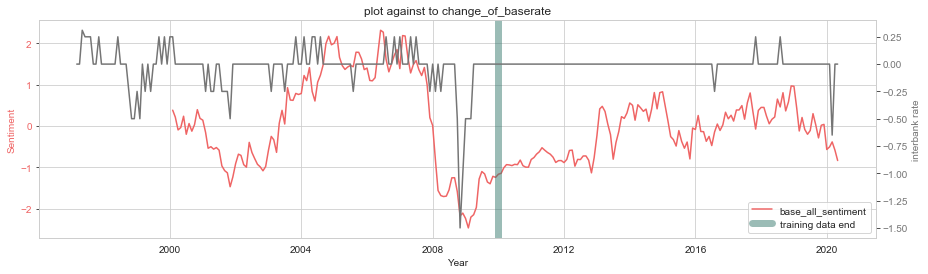

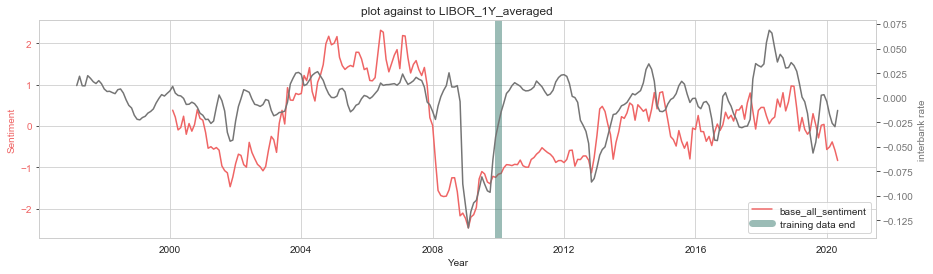

Correlation with Averaging
                   base_all_sentiment  LM_sentiment  FS_sentiment
LIBOR_1Y_averaged            0.447329      0.196003      0.228943
LIBOR_1Y_change              0.295483      0.078673      0.145516
LIBOR_6M_change              0.324540      0.096375      0.164947
LIBOR_3M_change              0.301776      0.088394      0.149276
LIBOR_1M_change              0.301449      0.090399      0.151964


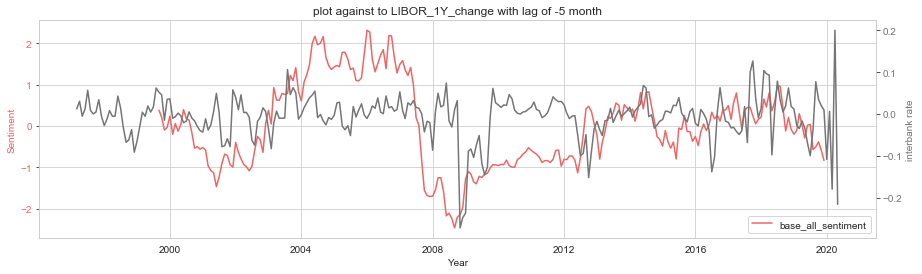

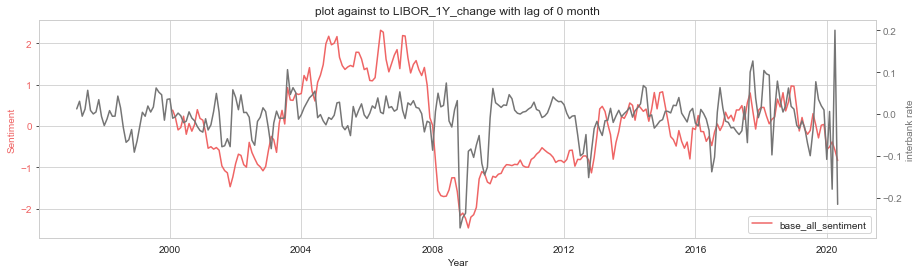

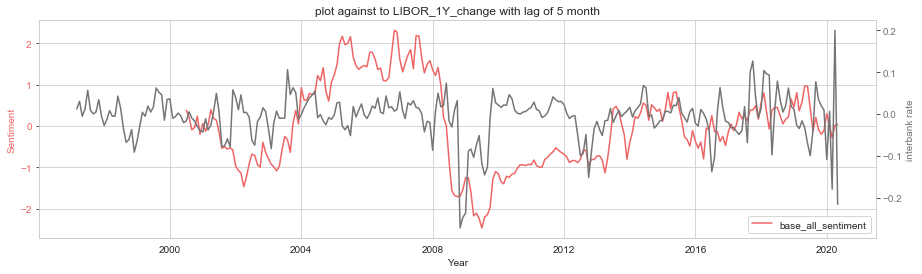

                   lag -5   lag -4   lag -3   lag -2    lag -1     lag 0  \
LIBOR_1Y_change  0.260504  0.27483  0.31094  0.31779  0.286817  0.295483   

                    lag 1     lag 2    lag 3     lag 4    lag 5  
LIBOR_1Y_change  0.288547  0.273587  0.24452  0.254403  0.25978  


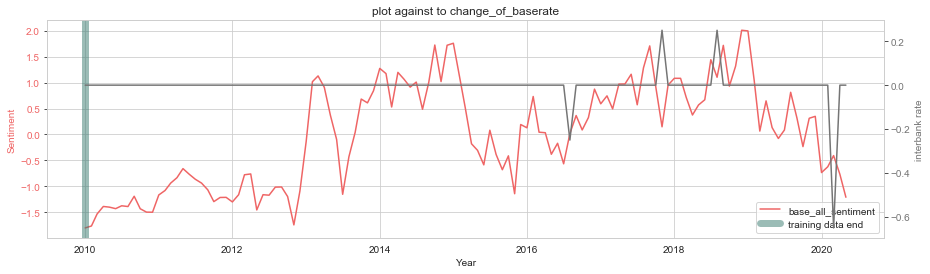

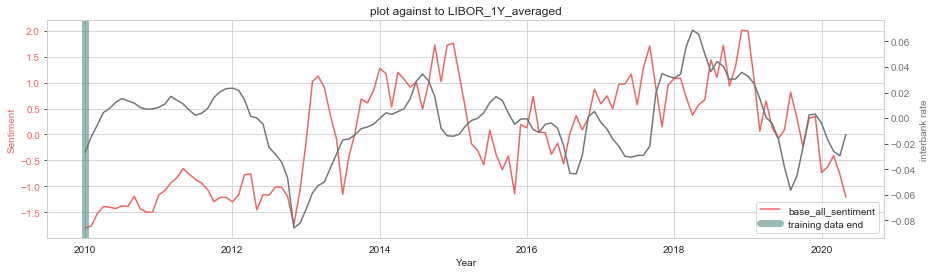

Correlation with Averaging
                   base_all_sentiment  LM_sentiment  FS_sentiment
LIBOR_1Y_averaged            0.147240      0.071518     -0.083387
LIBOR_1Y_change              0.130794     -0.086598     -0.110853
LIBOR_6M_change              0.159914     -0.096729     -0.110119
LIBOR_3M_change              0.140523     -0.101241     -0.111536
LIBOR_1M_change              0.137553     -0.105409     -0.125487


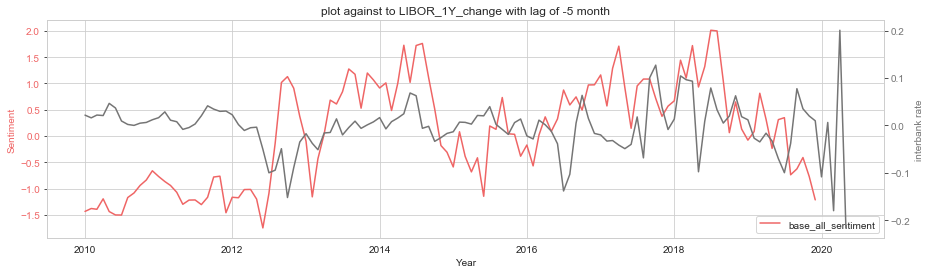

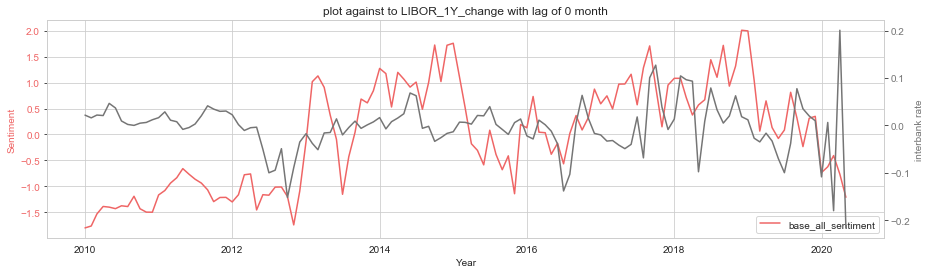

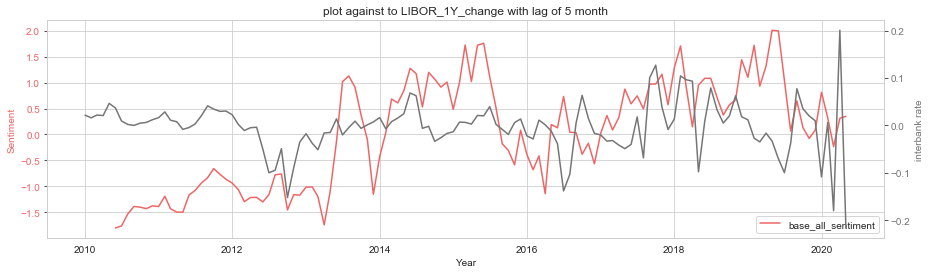

,lag -5,lag -4,lag -3,lag -2,lag -1,lag 0,lag 1,lag 2,lag 3,lag 4,lag 5
LIBOR_1Y_change,-0.009523,-0.003987,0.060792,0.071814,0.036432,0.130794,0.160092,0.127921,0.080082,0.119111,0.115636


In [731]:
halflife = 10
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_merged_prob = result_dictionary_sentiment_prob(model2,interested_topics,merged_timeseries_labelled)
result,result2 = rolling_averaging_ewm_3(sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type']=='BOE_Speech',:],end ='2020-06-28',N=halflife)
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['LIBOR_1Y_averaged','LIBOR_1Y_change','LIBOR_6M_change','LIBOR_3M_change','LIBOR_1M_change'],['base_all_sentiment','LM_sentiment','FS_sentiment']])

result.corr()
print(describe_lagged_information(result))

result,result2 = rolling_averaging_ewm_3(sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type']=='BOE_Speech',:],start=end_date,end ='2020-06-28',N=halflife)
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['LIBOR_1Y_averaged','LIBOR_1Y_change','LIBOR_6M_change','LIBOR_3M_change','LIBOR_1M_change'],['base_all_sentiment','LM_sentiment','FS_sentiment']])
result.corr()
describe_lagged_information(result)

# Step 2: Work with LSI model

## 2.1 bag of word representation

In [521]:
total_words = []
for n in range(len(final_df.cleaned_all)):
    total_words += final_df.cleaned_all[n]
total_words = set(total_words)
total_word_list = list(total_words)
total_word_list.sort()

BagOfWord = {i:[0 for i in range(len(final_df))] for i in total_word_list}

In [522]:
from tqdm import tqdm
for row in tqdm(range(len(final_df))):
    for word in final_df.iloc[row,1]:
        BagOfWord[word][row]+=1       
        

100%|██████████| 1821/1821 [00:02<00:00, 711.56it/s]


In [523]:
BagOfWord_df = pd.DataFrame(BagOfWord)
BagOfWord_df = BagOfWord_df.reindex(BagOfWord_df.sum().sort_values(ascending = False).index, axis=1)

In [778]:
n = total_word_list.index('inflat')
total_word_list[n-10:n+10]

['infer',
 'inferenti',
 'inferior',
 'infight',
 'infin',
 'infinit',
 'infinitesim',
 'infinitum',
 'infl',
 'infla',
 'inflat',
 'inflati',
 'inflatio',
 'inflatioin',
 'inflationa',
 'inflationan',
 'inflationand',
 'inflationari',
 'inflationaryexpect',
 'inflationaryimbal']

In [565]:
for word in ['inflat','unemploy','exchang','oil','uncertain','credit','petrol','interest','growth','risk']:
    n = total_word_list.index(word) # 351 column -> 341-361 columns
    for i in total_word_list[n-10:n+10]:
        print('{}:{}'.format(i,BagOfWord_df.sum()[i]))

infer:167
inferenti:2
inferior:17
infight:2
infin:7
infinit:25
infinitesim:1
infinitum:2
infl:6
infla:469
inflat:58447
inflati:1
inflatio:6
inflatioin:1
inflationa:2
inflationan:1
inflationand:2
inflationari:2630
inflationaryexpect:1
inflationaryimbal:1
unduli:115
undx:297
unearn:1
unearth:1
uneas:183
uneasi:12
uneasili:2
uneconom:5
unelect:12
unem:171
unemploy:9892
unemploymentchart:1
unemploymentr:2
unencumb:4
unend:1
unenvi:5
unequ:13
unequivoc:15
uner:1
uneth:4
exceedingli:3
excel:97
excep:40
except:1411
exceptionallystrong:8
exceptionallytight:1
exceptionalperform:1
excepton:1
excerpt:1
excess:1555
exchang:6331
exchangearrang:1
exchangei:1
exchangestabil:1
exchequ:83
excis:26
excit:57
excl:2
exclaim:1
exclud:1839
ofyear:1
ogniz:6
ogt:1
oh:3
ohlin:1
ohlsson:248
ohlssoncecilia:31
ohno:2
ohnsorg:1
oi:265
oil:5506
oiland:1
oilfield:2
oilmarket:1
oilpric:1
oilt:1
ointment:1
oitfiothna:1
ok:6
okay:2
unbroken:6
unbuilt:1
unbundl:20
unbureaucrat:1
unburn:1
uncanni:2
uncannili:4
uncar:1
un

In [566]:
BagOfWord_df2 = BagOfWord_df.copy()
def merge_and_replace(df,col_name,col_list):
    df.loc[:,col_name] = df.loc[:,col_list].sum(axis=1)
    df = df.drop(columns=col_list)
    return df
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Inflation',['inflat','inflationari'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Unemployment',['unemploy','unemploymentr'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Exchange',['exchang','exchangei','exchangestabil'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Oil price',['oil','oilmarket','oilpric','petrol','petroleum'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Uncertainty',['uncertain','uncertainti','uncertaintyi','uncertaintiessurround'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Credit',['credit','creditmarket','cred'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Interest',['interest','interestr','interestchart'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Growth',['growth','growthcontinu'])
BagOfWord_df2 = merge_and_replace(BagOfWord_df2,'Risk',['risk','riski','riskier'])

In [567]:
BagOfWord_df2.loc[:,'Doc_type'] = final_df.loc[:,'Type'].values
BagOfWord_df2.index = final_df.index
BagOfWord_df2 = BagOfWord_df2.loc['2000-01-01':,:]

## 2.2: compare different LSI structure

**UK minutes compare to other documents with speech**

In [782]:
topic_names = ['Inflation','Unemployment','Exchange','Oil price','Uncertainty','Credit','Interest','Growth','Risk']
K = len(topic_names)
def create_LSI_model(C_CB):
    u, s, vh = np.linalg.svd(C_CB, full_matrices=False)
    F = u[:,:K].dot(np.diag(s[:K]))
    L = vh.T[:,:K]
    L_0 = L[:K,:]
    L_1 = L[K:,:]
    F_hat = F.dot(L_0.T)
    L_hat = L.dot(np.linalg.inv(L_0))
    # modification: normalize F
    F_hat = (F_hat-F_hat.mean(axis=0))/F_hat.std(axis=0)
    return F_hat,L_hat


def wmw(F_hat_CB):
    new = F_hat_CB.copy()
    for i in range(2,np.shape(F_hat_CB)[0]):
        new[i,:] = 0.2*new[i-2,:]+0.3*new[i-1,:]+0.5*new[i,:]
    return new

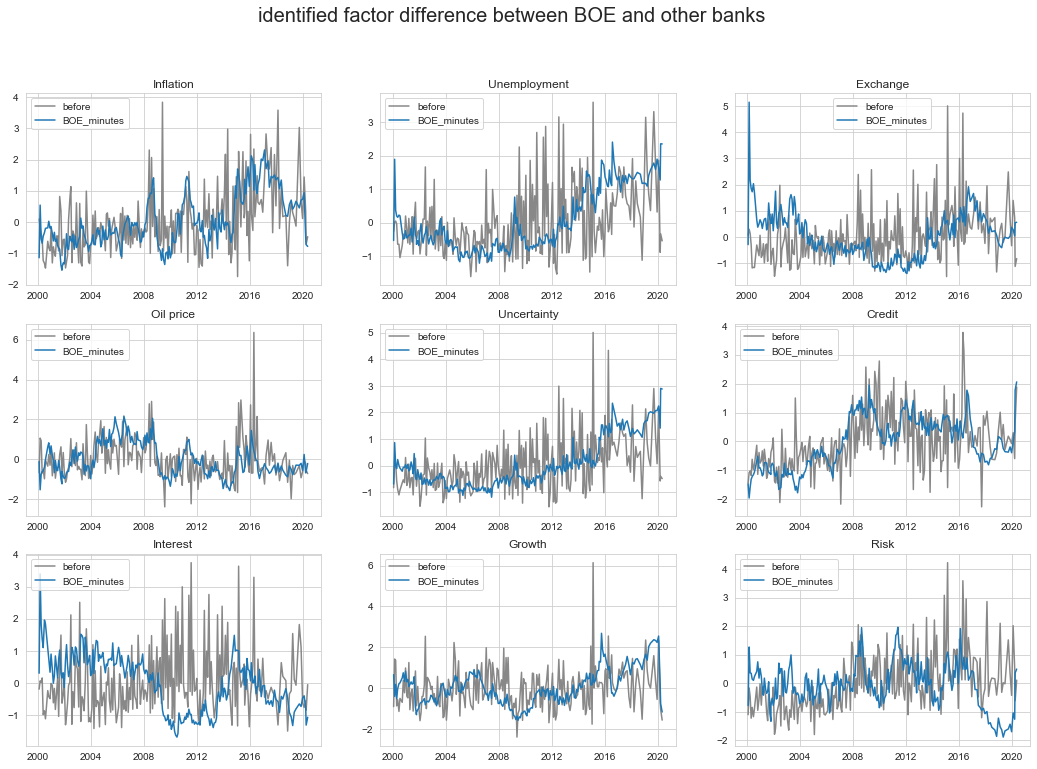

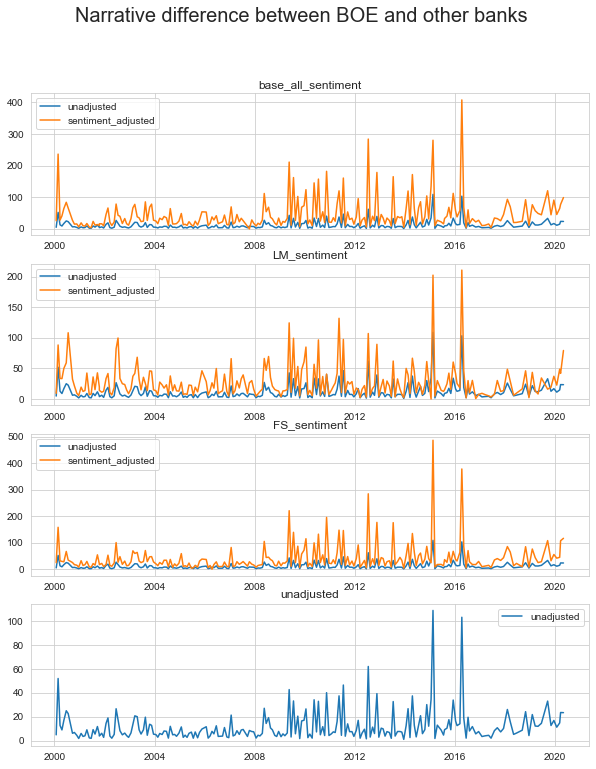

In [653]:
# all choice: 'BOE_minutes','FED_minutes','policy_press_conference_NOQA','policy_accounts','BOE_Speech','Sweden_minute'

interested_types = ['BOE_minutes']
other_types = ['FED_minutes','policy_press_conference_NOQA','policy_accounts','BOE_Speech','Sweden_minute']
W_before = 20
W_after = 20


C_CB = []
for i in interested_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    C_CB += [df]
C_CB = pd.concat(C_CB).sort_index().iloc[:,:-1]

RestOfDocs = []
for i in other_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    RestOfDocs += [df]
RestOfDocs = pd.concat(RestOfDocs).sort_index().iloc[:,:-1]


C_before = []
C_after =[]
for i in C_CB.index:
    C_before.append(RestOfDocs.loc[i-timedelta(days=W_before):i,:].mean().values.tolist())
    C_after.append(RestOfDocs.loc[i:i+timedelta(days=W_after),:].mean().values.tolist())
C_before=pd.DataFrame(C_before,index=C_CB.index,columns=C_CB.columns)
C_after=pd.DataFrame(C_after,index=C_CB.index,columns=C_CB.columns)

topic_names = C_CB.iloc[:,-K:].columns.tolist()
C_CB = pd.concat([C_CB.iloc[:,-K:],C_CB.iloc[:,:3500].sample(frac=1, axis=1)],axis=1)
C_before = C_before.loc[:,C_CB.columns]
C_after = C_after.loc[:,C_CB.columns]
C_CB = C_CB.loc[:,C_CB.sum()>3]
C_before = C_before.loc[:,C_before.sum()>3]
C_after = C_after.loc[:,C_after.sum()>3]
names = list(set.intersection(*map(set, [C_CB.columns, C_before.columns, C_after.columns])))
for item in topic_names:
    names.remove(item)
idx = (C_before.sum(axis=1)!=0) & (C_after.sum(axis=1)!=0)
C_CB = C_CB.loc[idx,topic_names+names]
C_before = C_before.loc[idx,topic_names+names]
C_after = C_after.loc[idx,topic_names+names]

idf = np.log(len(C_CB)/C_CB.sum())
C_CB = C_CB*idf
C_before = C_before*idf
C_after = C_after*idf

F_hat_CB,     L_hat_CB     = create_LSI_model(C_CB)
F_hat_before, L_hat_before = create_LSI_model(C_before)
F_hat_after , L_hat_after  = create_LSI_model(C_after)
F_hat_CB = wmw(F_hat_CB)

nd_hat_CB_before    = ((F_hat_CB-F_hat_before)**2).sum(axis=1)
nd_hat_after_before = ((F_hat_after-F_hat_before)**2).sum(axis=1)





Tone_CB = []
for i in interested_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    Tone_CB += [df]
Tone_CB = pd.concat(Tone_CB).sort_index()


other_sentiment = []
for i in other_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    other_sentiment += [df]
other_sentiment = pd.concat(other_sentiment).sort_index()

Tone_before = []
Tone_after =[]
for i in Tone_CB.index:
    Tone_before.append(other_sentiment.loc[i-timedelta(days=20):i,:].mean().values.tolist())
    Tone_after.append(other_sentiment.loc[i:i+timedelta(days=20),:].mean().values.tolist())
    
Tone_before=pd.DataFrame(Tone_before,index=Tone_CB.index,columns=Tone_CB.columns)
Tone_after=pd.DataFrame(Tone_after,index=Tone_CB.index,columns=Tone_CB.columns)

def normalize_df(df):
    return (df-df.min())/df.std()

Tone_CB = Tone_CB.loc[idx,:]
Tone_before = Tone_before.loc[idx,:]
Tone_after = Tone_after.loc[idx,:]


Tone_CB_before = normalize_df(Tone_CB - Tone_before)
Tone_after_before = normalize_df(Tone_after - Tone_before)


nd_CB_before  = Tone_CB_before.multiply(np.array([nd_hat_CB_before]*3).T)
nd_after_before  = Tone_after_before.multiply(np.array([nd_hat_after_before]*3).T)

plt.figure(figsize=(18,12))
plt.suptitle('identified factor difference between BOE and other banks',fontsize=20)
for n,i in enumerate(topic_names):
    plt.subplot(3,3,n+1)
    plt.plot(C_CB.index,-F_hat_before[:,n],color='#888888',label='before')
    plt.plot(C_CB.index,-F_hat_CB[:,n],label=interested_types[0])  # i flip the value because more negative means more focus on this topic
    plt.title(i)
    plt.legend()
plt.show()
print()
print()
plt.figure(figsize=(10,12))
for n,i in enumerate(nd_CB_before.columns):
    plt.subplot(4,1,n+1)
    plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
    plt.plot(C_CB.index, nd_CB_before.iloc[:,n],label='sentiment_adjusted')
    plt.title(i)
    plt.legend()
plt.subplot(4,1,4)
plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
plt.title('unadjusted')
plt.legend()    
    
plt.suptitle('Narrative difference between BOE and other banks',fontsize=20)
plt.show()

I have located the document that has the sudden explosion in numbers of inflation word apeared. And it seem that the explosion in number of word of inflation is not error, but the speech of BOE was talking about inflation explation

In [513]:
dataset.loc['2009-05-14',:].all_string.values

array([" The Monetary Policy Committee (MPC) at the Bank of England has an explicit mandate  to maintain CPI inflation at a target of % In such an inflation targeting  regime,  the  effectiveness of monetary policy is likely to be greater if inflation expectations remain anchored  to the target People have to believe that there will be low inflation before they stop building expectations of high inflation into their decision-making process A sustained rise in inflation expectations in the short-term runs the risk of heightened inflationary pressures in the medium term Hence, central banks have an incentive to understand how inflation expectations  are  formed The formation of inflation expectations is likely to be related to the credibility of the monetary authority in controlling inflation We therefore also consider micro data on individuals  satisfaction with the Bank of England in its job to control inflation We also consider the characteristics of those individuals more likely to a

**Now let me try without boe speech**

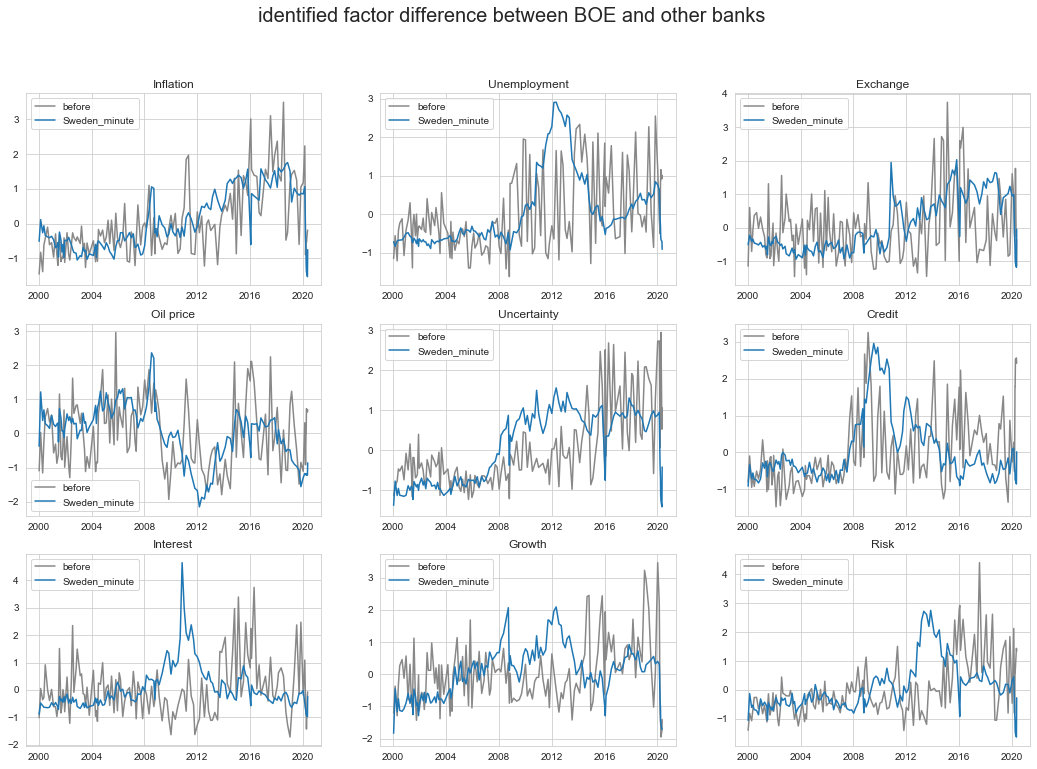

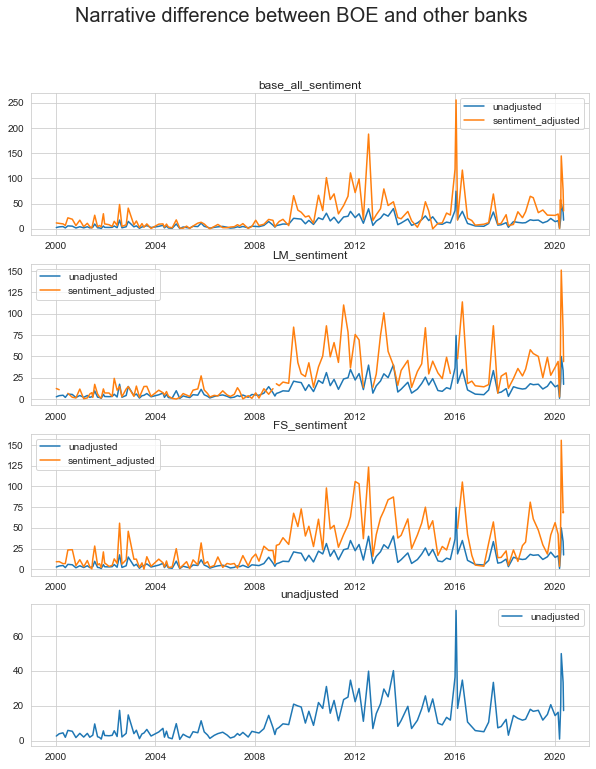

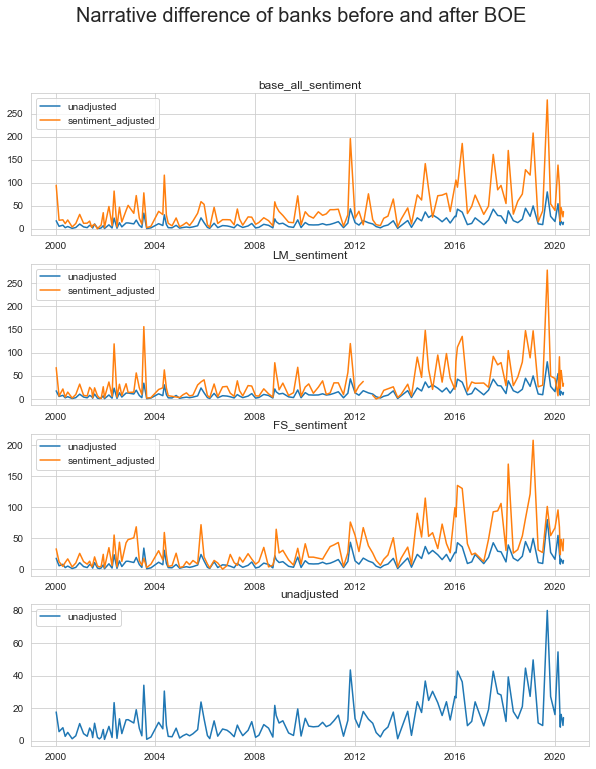

In [783]:
interested_types = ['Sweden_minute']
other_types = ['FED_minutes','policy_press_conference_NOQA','policy_accounts','BOE_minutes']
W_before = 20
W_after = 20


C_CB = []
for i in interested_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    C_CB += [df]
C_CB = pd.concat(C_CB).sort_index().iloc[:,:-1]

RestOfDocs = []
for i in other_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    RestOfDocs += [df]
RestOfDocs = pd.concat(RestOfDocs).sort_index().iloc[:,:-1]


C_before = []
C_after =[]
for i in C_CB.index:
    C_before.append(RestOfDocs.loc[i-timedelta(days=W_before):i,:].mean().values.tolist())
    C_after.append(RestOfDocs.loc[i:i+timedelta(days=W_after),:].mean().values.tolist())
C_before=pd.DataFrame(C_before,index=C_CB.index,columns=C_CB.columns)
C_after=pd.DataFrame(C_after,index=C_CB.index,columns=C_CB.columns)

topic_names = C_CB.iloc[:,-K:].columns.tolist()
C_CB = pd.concat([C_CB.iloc[:,-K:],C_CB.iloc[:,:3500].sample(frac=1, axis=1)],axis=1)
C_before = C_before.loc[:,C_CB.columns]
C_after = C_after.loc[:,C_CB.columns]
C_CB = C_CB.loc[:,C_CB.sum()>3]
C_before = C_before.loc[:,C_before.sum()>3]
C_after = C_after.loc[:,C_after.sum()>3]
names = list(set.intersection(*map(set, [C_CB.columns, C_before.columns, C_after.columns])))
for item in topic_names:
    names.remove(item)
idx = (C_before.sum(axis=1)!=0) & (C_after.sum(axis=1)!=0)
C_CB = C_CB.loc[idx,topic_names+names]
C_before = C_before.loc[idx,topic_names+names]
C_after = C_after.loc[idx,topic_names+names]

idf = np.log(len(C_CB)/C_CB.sum())
C_CB = C_CB*idf
C_before = C_before*idf
C_after = C_after*idf

F_hat_CB,     L_hat_CB     = create_LSI_model(C_CB)
F_hat_before, L_hat_before = create_LSI_model(C_before)
F_hat_after , L_hat_after  = create_LSI_model(C_after)
F_hat_CB = wmw(F_hat_CB)


nd_hat_CB_before    = ((F_hat_CB-F_hat_before)**2).sum(axis=1)
nd_hat_after_before = ((F_hat_after-F_hat_before)**2).sum(axis=1)





Tone_CB = []
for i in interested_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    Tone_CB += [df]
Tone_CB = pd.concat(Tone_CB).sort_index()


other_sentiment = []
for i in other_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    other_sentiment += [df]
other_sentiment = pd.concat(other_sentiment).sort_index()

Tone_before = []
Tone_after =[]
for i in Tone_CB.index:
    Tone_before.append(other_sentiment.loc[i-timedelta(days=20):i,:].mean().values.tolist())
    Tone_after.append(other_sentiment.loc[i:i+timedelta(days=20),:].mean().values.tolist())
    
Tone_before=pd.DataFrame(Tone_before,index=Tone_CB.index,columns=Tone_CB.columns)
Tone_after=pd.DataFrame(Tone_after,index=Tone_CB.index,columns=Tone_CB.columns)

def normalize_df(df):
    return (df-df.min())/df.std()

Tone_CB = Tone_CB.loc[idx,:]
Tone_before = Tone_before.loc[idx,:]
Tone_after = Tone_after.loc[idx,:]


Tone_CB_before = normalize_df(Tone_CB - Tone_before)
Tone_after_before = normalize_df(Tone_after - Tone_before)


nd_CB_before  = Tone_CB_before.multiply(np.array([nd_hat_CB_before]*3).T)
nd_after_before  = Tone_after_before.multiply(np.array([nd_hat_after_before]*3).T)

plt.figure(figsize=(18,12))
plt.suptitle('identified factor difference between BOE and other banks',fontsize=20)
for n,i in enumerate(topic_names):
    plt.subplot(3,3,n+1)
    plt.plot(C_CB.index,-F_hat_before[:,n],color='#888888',label='before')
    plt.plot(C_CB.index,-F_hat_CB[:,n],label=interested_types[0])  # i flip the value because more negative means more focus on this topic
    plt.title(i)
    plt.legend()
plt.show()
print()
print()
plt.figure(figsize=(10,12))
for n,i in enumerate(nd_CB_before.columns):
    plt.subplot(4,1,n+1)
    plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
    plt.plot(C_CB.index, nd_CB_before.iloc[:,n],label='sentiment_adjusted')
    plt.title(i)
    plt.legend()
plt.subplot(4,1,4)
plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
plt.title('unadjusted')
plt.legend()    
    
plt.suptitle('Narrative difference between BOE and other banks',fontsize=20)
plt.show()



plt.figure(figsize=(10,12))
for n,i in enumerate(nd_CB_before.columns):
    plt.subplot(4,1,n+1)
    plt.plot(C_CB.index, nd_hat_after_before, label='unadjusted')
    plt.plot(C_CB.index, nd_after_before.iloc[:,n],label='sentiment_adjusted')
    plt.title(i)
    plt.legend()
plt.subplot(4,1,4)
plt.plot(C_CB.index, nd_hat_after_before, label='unadjusted')
plt.title('unadjusted')
plt.legend()    
    
plt.suptitle('Narrative difference of banks before and after BOE',fontsize=20)
plt.show()

In [757]:
from sklearn.metrics.pairwise import cosine_similarity
for k in range(9):
    similarity = []
    for n,i in enumerate(C_CB.columns):
        similarity.append([cosine_similarity(L_hat_before[[k],:], L_hat_before[[n],:], dense_output=True),i])
        similarity.sort(reverse=True)
    print([i[1] for i in similarity[:10]])

['Inflation', 'heighten', 'answer', 'thin', 'regain', 'pictur', 'fall', 'settl', 'headwind', 'stimul']
['Unemployment', 'partner', 'downturn', 'technic', 'regain', 'definit', 'visibl', 'prematur', 'attent', 'stimul']
['Exchange', 'repeatedli', 'last', 'exit', 'fourth', 'limit', 'januari', 'borrow', 'water', 'toler']
['Oil price', 'fall', 'lf', 'regain', 'bound', 'definit', 'heighten', 'prematur', 'technic', 'baselin']
['Uncertainty', 'lend', 'sterl', 'also', 'volatil', 'pmi', 'claim', 'subsidi', 'emerg', 'cut']
['Credit', 'borrow', 'redund', 'water', 'base', 'purchas', 'limit', 'remain', 'bond', 'januari']
['Interest', 'fall', 'borrow', 'pictur', 'stronger', 'lf', 'headwind', 'membership', 'bound', 'consequ']
['Growth', 'stimul', 'bound', 'repres', 'explan', 'similarli', 'ceil', 'endur', 'answer', 'question']
['Risk', 'debt', 'bond', 'detect', 'purchas', 'costli', 'import', 'congress', 'greatli', 'lower']


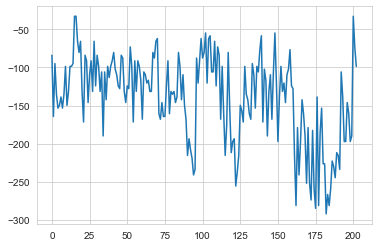

In [772]:
plt.plot(C_CB.loc[:,'Inflation'].values)


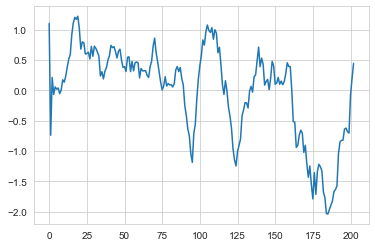

In [774]:
plt.plot(F_hat_CB[:,0])

**Compare fed to other banks**

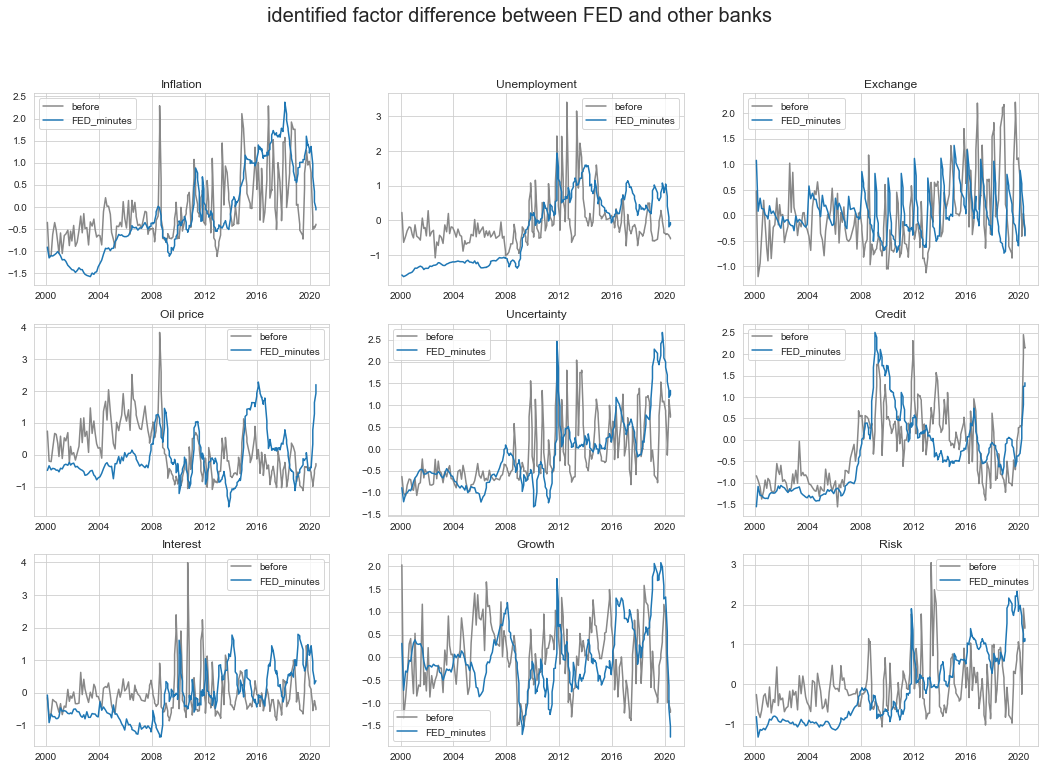

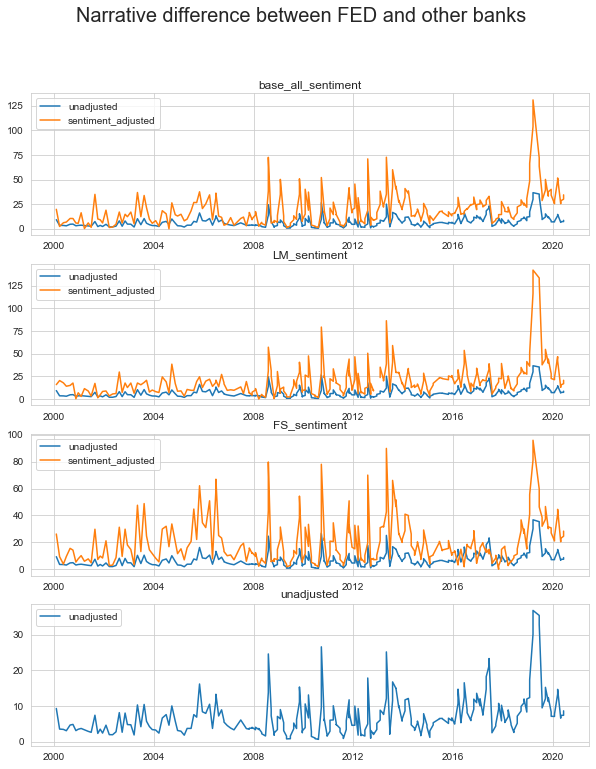

In [659]:
interested_types = ['FED_minutes']
other_types = ['BOE_minutes','policy_press_conference_NOQA','policy_accounts','Sweden_minute']
W_before = 20
W_after = 20


C_CB = []
for i in interested_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    C_CB += [df]
C_CB = pd.concat(C_CB).sort_index().iloc[:,:-1]

RestOfDocs = []
for i in other_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    RestOfDocs += [df]
RestOfDocs = pd.concat(RestOfDocs).sort_index().iloc[:,:-1]


C_before = []
C_after =[]
for i in C_CB.index:
    C_before.append(RestOfDocs.loc[i-timedelta(days=W_before):i,:].mean().values.tolist())
    C_after.append(RestOfDocs.loc[i:i+timedelta(days=W_after),:].mean().values.tolist())
C_before=pd.DataFrame(C_before,index=C_CB.index,columns=C_CB.columns)
C_after=pd.DataFrame(C_after,index=C_CB.index,columns=C_CB.columns)

topic_names = C_CB.iloc[:,-K:].columns.tolist()
C_CB = pd.concat([C_CB.iloc[:,-K:],C_CB.iloc[:,:3500].sample(frac=1, axis=1)],axis=1)
C_before = C_before.loc[:,C_CB.columns]
C_after = C_after.loc[:,C_CB.columns]
C_CB = C_CB.loc[:,C_CB.sum()>3]
C_before = C_before.loc[:,C_before.sum()>3]
C_after = C_after.loc[:,C_after.sum()>3]
names = list(set.intersection(*map(set, [C_CB.columns, C_before.columns, C_after.columns])))
for item in topic_names:
    names.remove(item)
idx = (C_before.sum(axis=1)!=0) & (C_after.sum(axis=1)!=0)
C_CB = C_CB.loc[idx,topic_names+names]
C_before = C_before.loc[idx,topic_names+names]
C_after = C_after.loc[idx,topic_names+names]

idf = np.log(len(C_CB)/C_CB.sum())
C_CB = C_CB*idf
C_before = C_before*idf
C_after = C_after*idf

F_hat_CB,     L_hat_CB     = create_LSI_model(C_CB)
F_hat_before, L_hat_before = create_LSI_model(C_before)
F_hat_after , L_hat_after  = create_LSI_model(C_after)
F_hat_CB = wmw(F_hat_CB)


nd_hat_CB_before    = ((F_hat_CB-F_hat_before)**2).sum(axis=1)
nd_hat_after_before = ((F_hat_after-F_hat_before)**2).sum(axis=1)





Tone_CB = []
for i in interested_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    Tone_CB += [df]
Tone_CB = pd.concat(Tone_CB).sort_index()


other_sentiment = []
for i in other_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    other_sentiment += [df]
other_sentiment = pd.concat(other_sentiment).sort_index()

Tone_before = []
Tone_after =[]
for i in Tone_CB.index:
    Tone_before.append(other_sentiment.loc[i-timedelta(days=20):i,:].mean().values.tolist())
    Tone_after.append(other_sentiment.loc[i:i+timedelta(days=20),:].mean().values.tolist())
    
Tone_before=pd.DataFrame(Tone_before,index=Tone_CB.index,columns=Tone_CB.columns)
Tone_after=pd.DataFrame(Tone_after,index=Tone_CB.index,columns=Tone_CB.columns)

def normalize_df(df):
    return (df-df.min())/df.std()

Tone_CB = Tone_CB.loc[idx,:]
Tone_before = Tone_before.loc[idx,:]
Tone_after = Tone_after.loc[idx,:]


Tone_CB_before = normalize_df(Tone_CB - Tone_before)
Tone_after_before = normalize_df(Tone_after - Tone_before)


nd_CB_before  = Tone_CB_before.multiply(np.array([nd_hat_CB_before]*3).T)
nd_after_before  = Tone_after_before.multiply(np.array([nd_hat_after_before]*3).T)

plt.figure(figsize=(18,12))
plt.suptitle('identified factor difference between FED and other banks',fontsize=20)
for n,i in enumerate(topic_names):
    plt.subplot(3,3,n+1)
    plt.plot(C_CB.index,-F_hat_before[:,n],color='#888888',label='before')
    plt.plot(C_CB.index,-F_hat_CB[:,n],label=interested_types[0])  # i flip the value because more negative means more focus on this topic
    plt.title(i)
    plt.legend()
plt.show()
print()
print()
plt.figure(figsize=(10,12))
for n,i in enumerate(nd_CB_before.columns):
    plt.subplot(4,1,n+1)
    plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
    plt.plot(C_CB.index, nd_CB_before.iloc[:,n],label='sentiment_adjusted')
    plt.title(i)
    plt.legend()
plt.subplot(4,1,4)
plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
plt.title('unadjusted')
plt.legend()    
    
plt.suptitle('Narrative difference between FED and other banks',fontsize=20)
plt.show()

**check topical focus of speech**

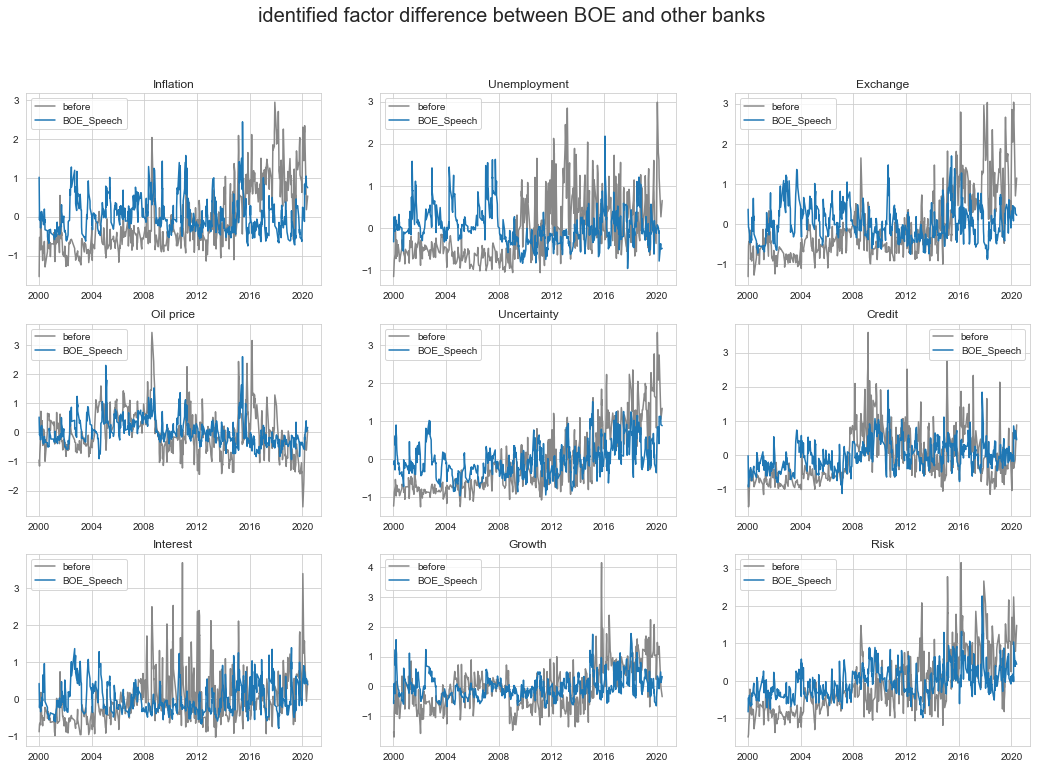

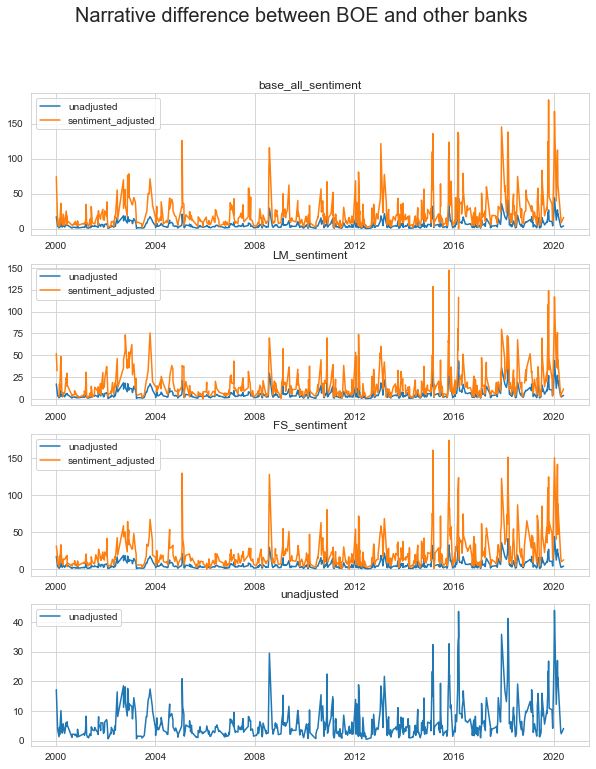

In [658]:
interested_types = ['BOE_Speech']
other_types = ['BOE_minutes','FED_minutes','policy_press_conference_NOQA','policy_accounts','Sweden_minute']
W_before = 20
W_after = 20


C_CB = []
for i in interested_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    C_CB += [df]
C_CB = pd.concat(C_CB).sort_index().iloc[:,:-1]

RestOfDocs = []
for i in other_types:
    df = BagOfWord_df2.loc[BagOfWord_df2.loc[:,'Doc_type'] ==i,:]
    RestOfDocs += [df]
RestOfDocs = pd.concat(RestOfDocs).sort_index().iloc[:,:-1]


C_before = []
C_after =[]
for i in C_CB.index:
    C_before.append(RestOfDocs.loc[i-timedelta(days=W_before):i,:].mean().values.tolist())
    C_after.append(RestOfDocs.loc[i:i+timedelta(days=W_after),:].mean().values.tolist())
C_before=pd.DataFrame(C_before,index=C_CB.index,columns=C_CB.columns)
C_after=pd.DataFrame(C_after,index=C_CB.index,columns=C_CB.columns)

topic_names = C_CB.iloc[:,-K:].columns.tolist()
C_CB = pd.concat([C_CB.iloc[:,-K:],C_CB.iloc[:,:3500].sample(frac=1, axis=1)],axis=1)
C_before = C_before.loc[:,C_CB.columns]
C_after = C_after.loc[:,C_CB.columns]
C_CB = C_CB.loc[:,C_CB.sum()>3]
C_before = C_before.loc[:,C_before.sum()>3]
C_after = C_after.loc[:,C_after.sum()>3]
names = list(set.intersection(*map(set, [C_CB.columns, C_before.columns, C_after.columns])))
for item in topic_names:
    names.remove(item)
idx = (C_before.sum(axis=1)!=0) & (C_after.sum(axis=1)!=0)
C_CB = C_CB.loc[idx,topic_names+names]
C_before = C_before.loc[idx,topic_names+names]
C_after = C_after.loc[idx,topic_names+names]

idf = np.log(len(C_CB)/C_CB.sum())
C_CB = C_CB*idf
C_before = C_before*idf
C_after = C_after*idf

F_hat_CB,     L_hat_CB     = create_LSI_model(C_CB)
F_hat_before, L_hat_before = create_LSI_model(C_before)
F_hat_after , L_hat_after  = create_LSI_model(C_after)
F_hat_CB = wmw(F_hat_CB)

nd_hat_CB_before    = ((F_hat_CB-F_hat_before)**2).sum(axis=1)
nd_hat_after_before = ((F_hat_after-F_hat_before)**2).sum(axis=1)





Tone_CB = []
for i in interested_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    Tone_CB += [df]
Tone_CB = pd.concat(Tone_CB).sort_index()


other_sentiment = []
for i in other_types:
    df = sentiment_97_10_merged_prob.loc[sentiment_97_10_merged_prob.loc[:,'Type'] ==i,['base_all_sentiment','LM_sentiment','FS_sentiment']]
    other_sentiment += [df]
other_sentiment = pd.concat(other_sentiment).sort_index()

Tone_before = []
Tone_after =[]
for i in Tone_CB.index:
    Tone_before.append(other_sentiment.loc[i-timedelta(days=20):i,:].mean().values.tolist())
    Tone_after.append(other_sentiment.loc[i:i+timedelta(days=20),:].mean().values.tolist())
    
Tone_before=pd.DataFrame(Tone_before,index=Tone_CB.index,columns=Tone_CB.columns)
Tone_after=pd.DataFrame(Tone_after,index=Tone_CB.index,columns=Tone_CB.columns)

def normalize_df(df):
    return (df-df.min())/df.std()

Tone_CB = Tone_CB.loc[idx,:]
Tone_before = Tone_before.loc[idx,:]
Tone_after = Tone_after.loc[idx,:]


Tone_CB_before = normalize_df(Tone_CB - Tone_before)
Tone_after_before = normalize_df(Tone_after - Tone_before)


nd_CB_before  = Tone_CB_before.multiply(np.array([nd_hat_CB_before]*3).T)
nd_after_before  = Tone_after_before.multiply(np.array([nd_hat_after_before]*3).T)

plt.figure(figsize=(18,12))
plt.suptitle('identified factor difference between BOE and other banks',fontsize=20)
for n,i in enumerate(topic_names):
    plt.subplot(3,3,n+1)
    plt.plot(C_CB.index,-F_hat_before[:,n],color='#888888',label='before')
    plt.plot(C_CB.index,-F_hat_CB[:,n],label=interested_types[0])  # i flip the value because more negative means more focus on this topic
    plt.title(i)
    plt.legend()
plt.show()
print()
print()
plt.figure(figsize=(10,12))
for n,i in enumerate(nd_CB_before.columns):
    plt.subplot(4,1,n+1)
    plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
    plt.plot(C_CB.index, nd_CB_before.iloc[:,n],label='sentiment_adjusted')
    plt.title(i)
    plt.legend()
plt.subplot(4,1,4)
plt.plot(C_CB.index, nd_hat_CB_before, label='unadjusted')
plt.title('unadjusted')
plt.legend()    
    
plt.suptitle('Narrative difference between BOE and other banks',fontsize=20)
plt.show()

In [650]:
np.shape(F_hat_CB)

(730, 9)